# Trabalho A1 - Tiago Barradas - 243902

## Part 1 - Data loading and pre-processing

Primeiramente, vamos baixar o dataset e começar a explorá-lo em busca de problemas.

In [2]:
import os
import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=11)
mpl.rc('xtick', labelsize=13)
mpl.rc('ytick', labelsize=13)
mpl.rc('grid', alpha=0)
import seaborn as sns



# Baixa o dataset
URL = "https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv"
DATASET_PATH = os.path.join("dataset", "diamonds.csv")
os.makedirs("dataset", exist_ok=True)
urllib.request.urlretrieve(URL, DATASET_PATH)

diamonds = pd.read_csv(DATASET_PATH)

In [2]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


A princípo, não há nenhum datapoint com features faltantes, o que é um ótimo começo. Vamos agora checar se há datapoints repetidos:

In [3]:
diamonds.duplicated().value_counts()

False    53794
True       146
dtype: int64

In [4]:
diamonds = diamonds[~diamonds.duplicated()]
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


Após remover os datapoints repetidos usando o método .duplicated(), temos um dataset com 53794 entradas. Para evitar quaisquer problemas com índices faltantes, irei resetar os índices para que eles possuam um range adequado. Depois disso, vamos checar as features "cut", "color", e "clarity" para nos certificar que todos possuem valores adequados, conforme a [referência indicada](https://ggplot2.tidyverse.org/reference/diamonds.html).

In [5]:
diamonds.reset_index(inplace=True, drop=True)
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53794 entries, 0 to 53793
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
diamonds["cut"].value_counts()


Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: cut, dtype: int64

In [7]:
diamonds["color"].value_counts()


G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: color, dtype: int64

In [8]:
diamonds["clarity"].value_counts()

SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: clarity, dtype: int64

Agora que nos certificamos que o dataset está limpo, vamos trabalhar nos histogramas:

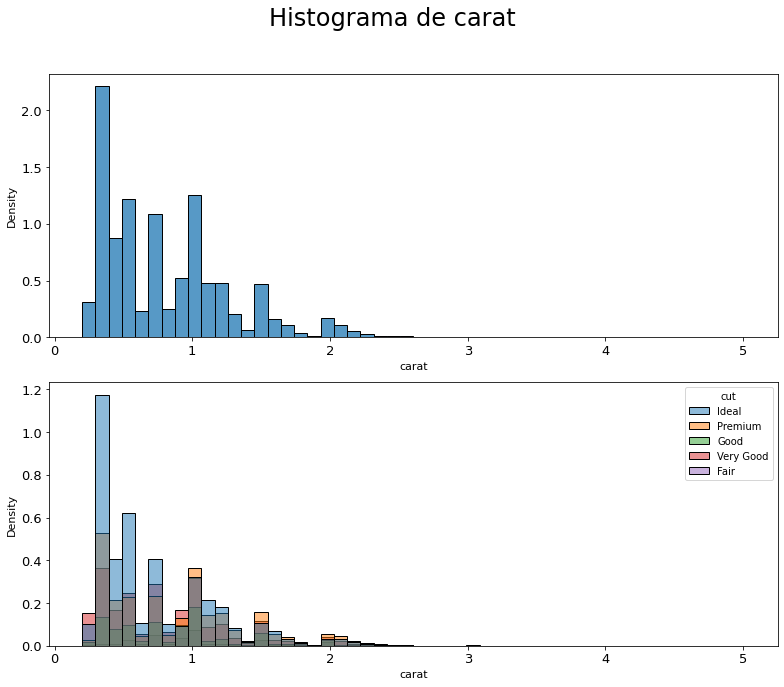

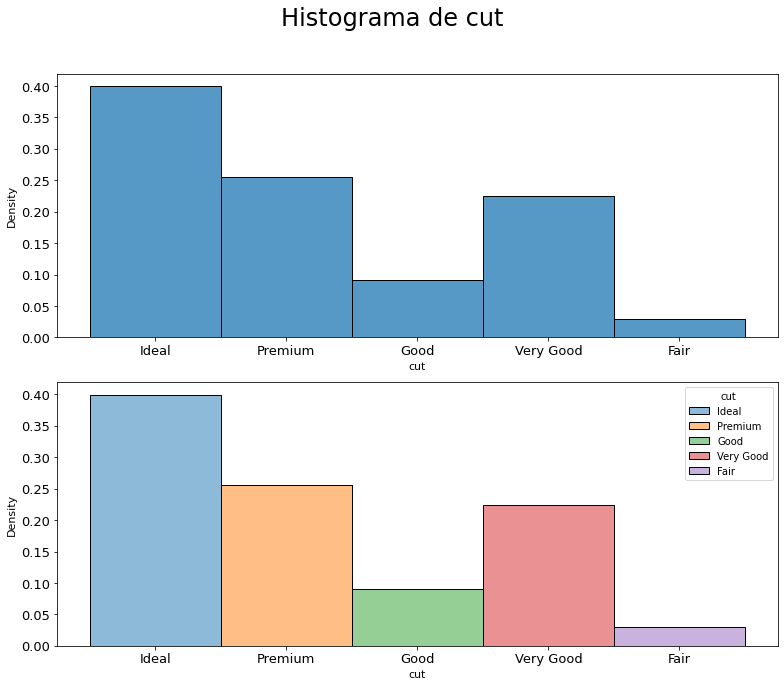

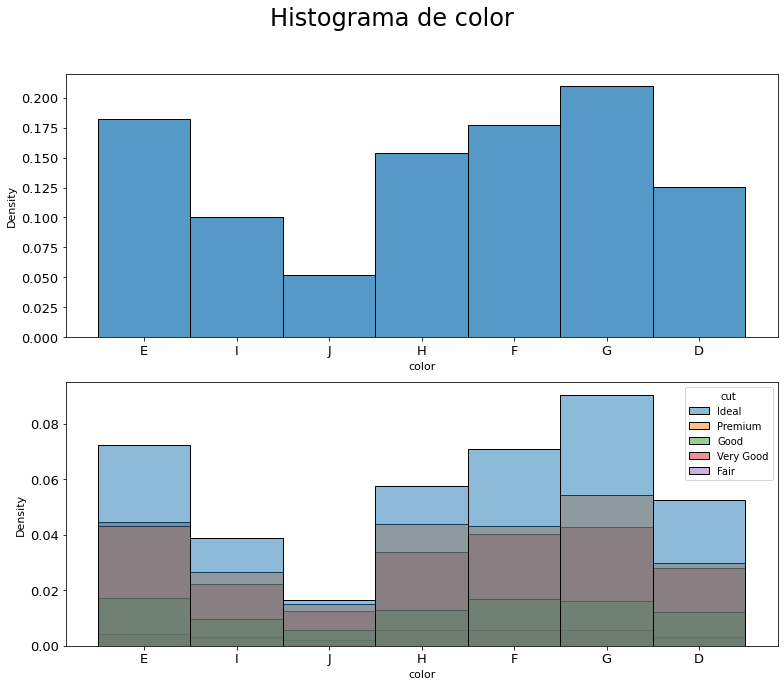

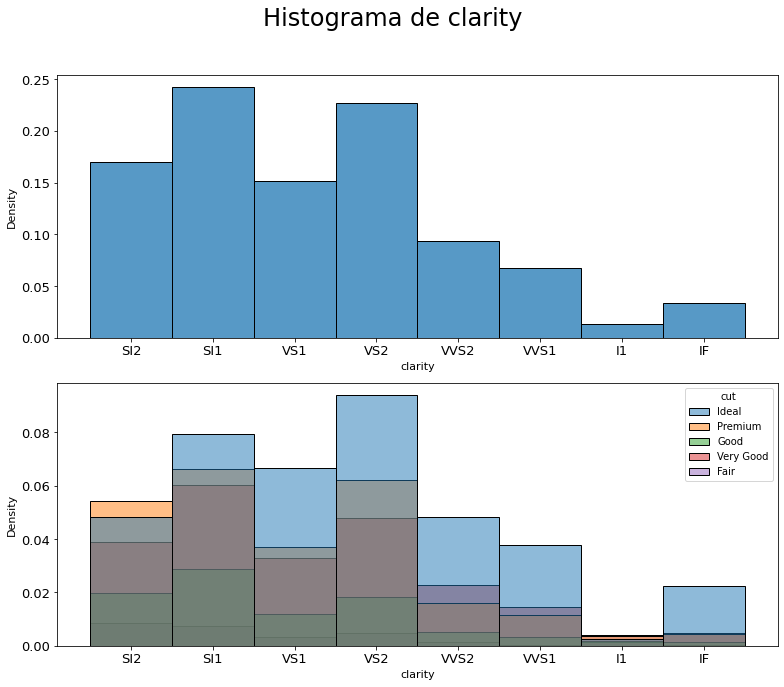

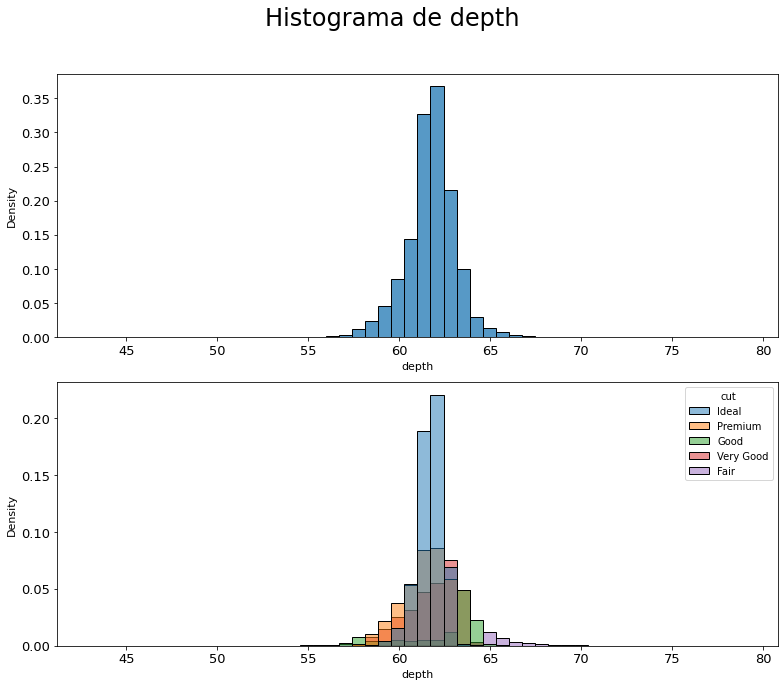

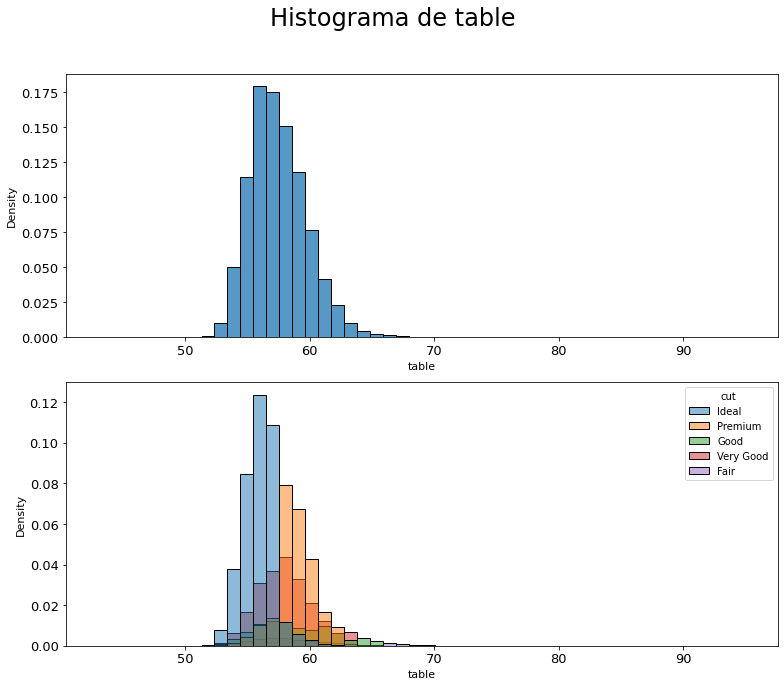

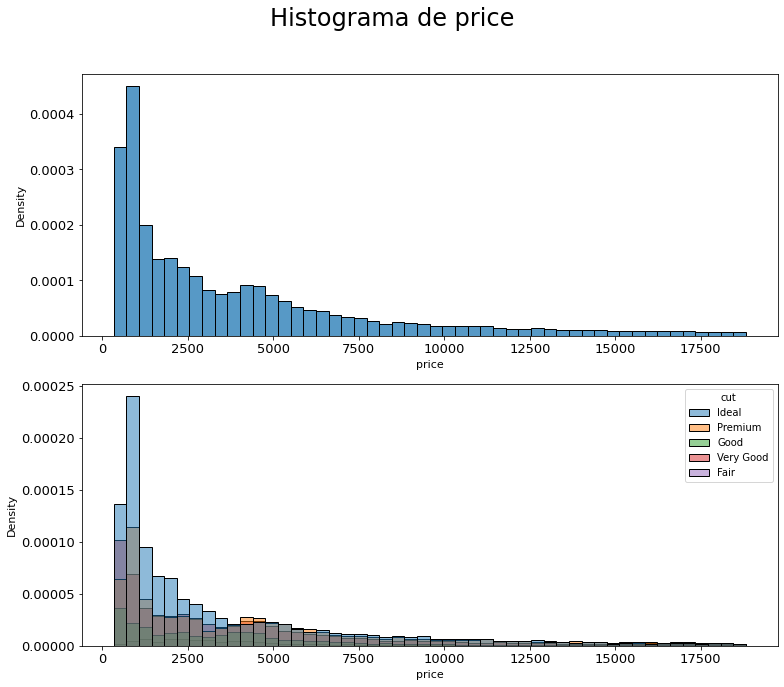

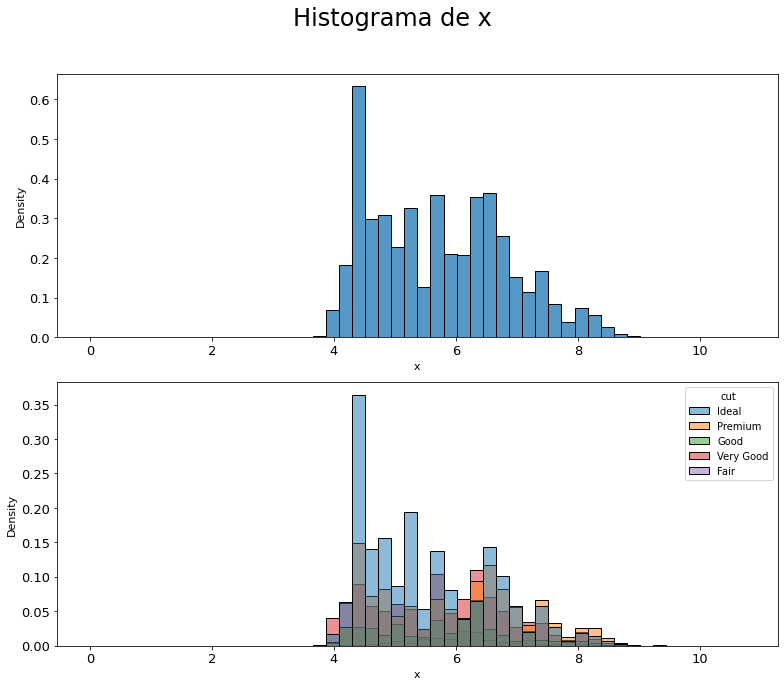

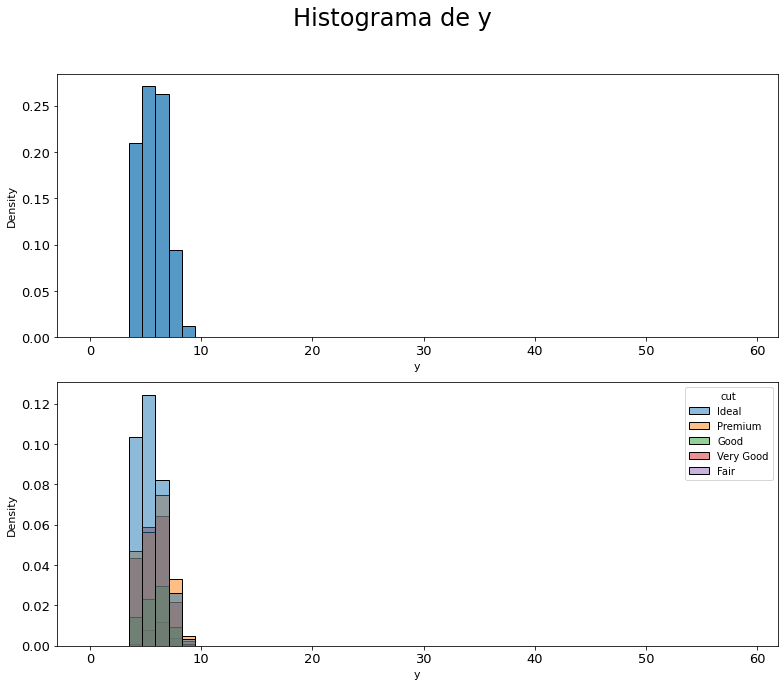

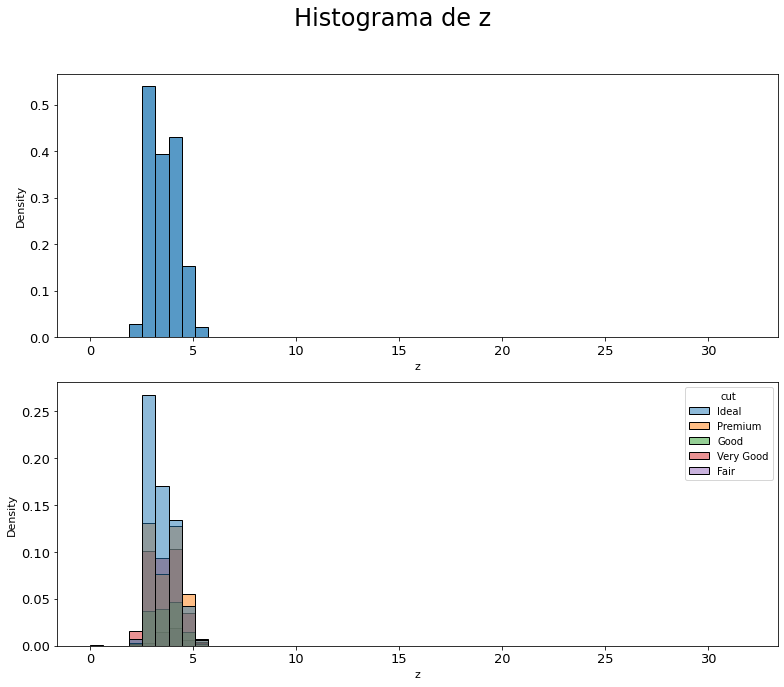

In [9]:
classes = diamonds["cut"].value_counts().index 


for key in diamonds.keys():
    fig, axs = plt.subplots(2, figsize=(11, 10))
    fig.suptitle(f"Histograma de {key}", fontsize=24)
    sns.histplot(ax=axs[0], data=diamonds, x=diamonds[key], 
                 stat='density', bins=50, common_norm=True)

    sns.histplot(ax=axs[1], data=diamonds, x=diamonds[key], 
                 stat='density', bins=50, common_norm=True, hue="cut")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()

Com os histogramas feitos, vamos agora fazer nossa matriz de figuras, contendo histogramas e scatterplots que mostram a correlação entre as diversas features:

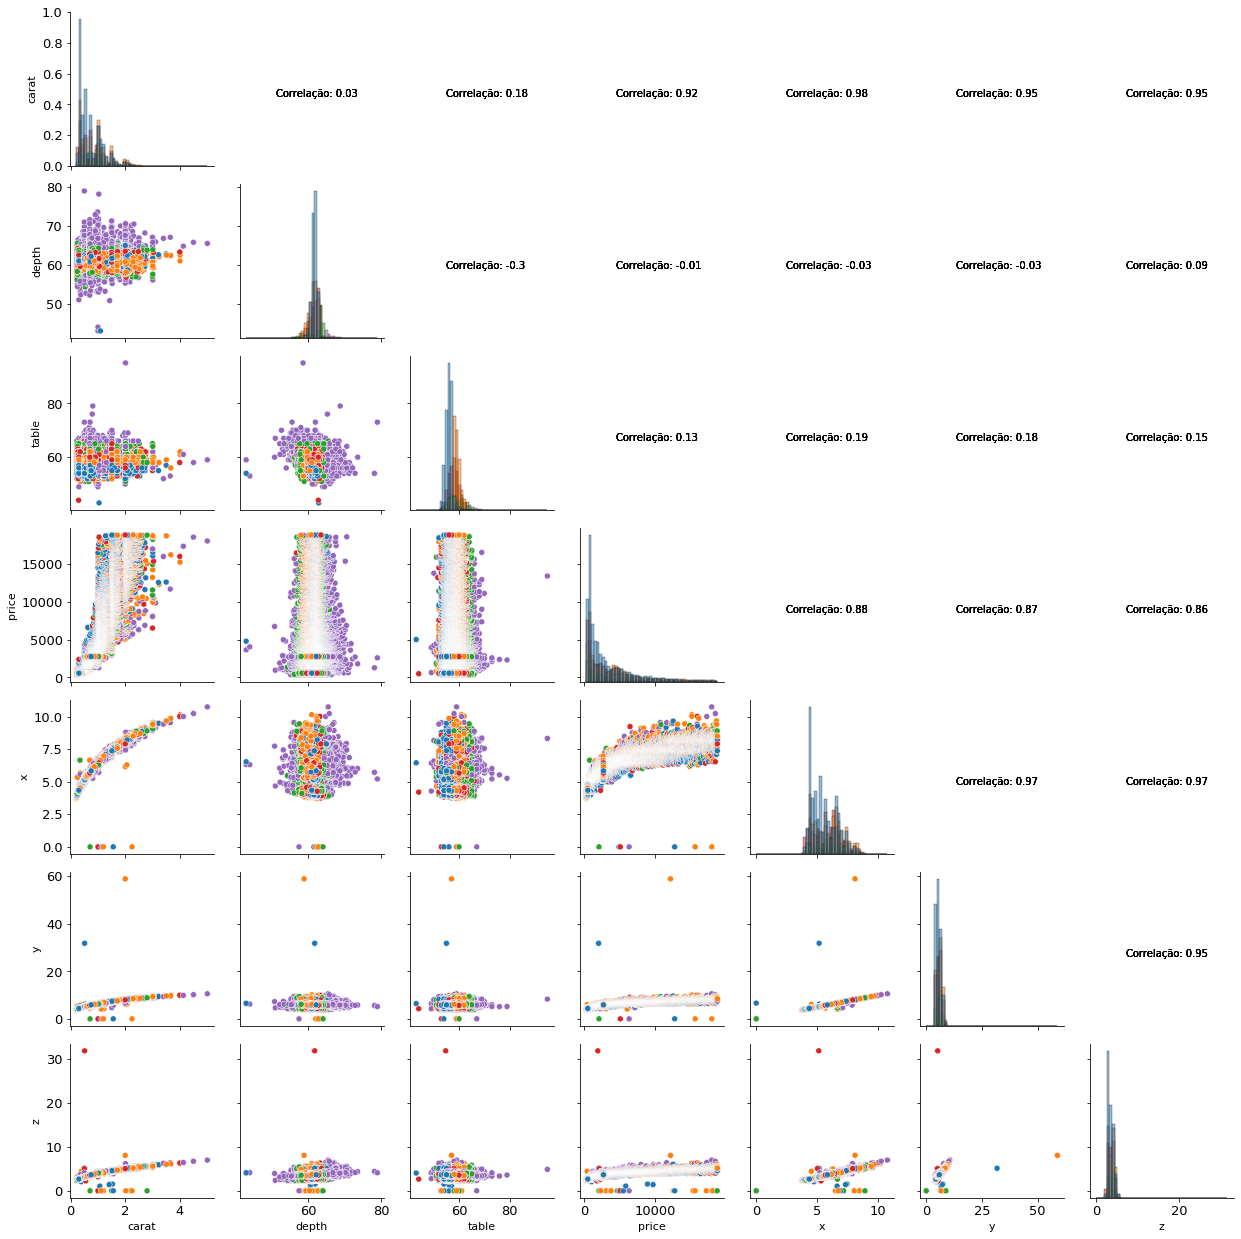

In [10]:
def correlation(x, y, **kws):
    corr = np.corrcoef(diamonds[x.name], diamonds[y.name])
    ax = plt.gca()  # Get current axis from the whole figure
    ax.annotate(f"Correlação: {round(corr[0, 1], 2)}", 
                xy=(0.25, 0.45), xycoords=ax.transAxes)
    plt.axis('off')


plot_matrix = sns.PairGrid(diamonds, hue='cut', diag_sharey=False)
plot_matrix.map_diag(sns.histplot, stat='density', bins=50, common_norm=True)
plot_matrix.map_lower(sns.scatterplot)
plot_matrix.map_upper(correlation)

Com isso, a primeira parte está concluída!

## Part 2 - K-nearest-neighbour classifier

Vamos dividir nosso dataset em training, validation e testing sets, e normalizar os valores presentes em cada feature do dataset para que elas passem a compartilhar uma mesma escala. Para isso, é necessário primeiro remover as variáveis categóricas do dataset.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


X_diamonds = diamonds.drop(["cut", "color", "clarity"], axis=1)
y_diamonds = diamonds["cut"]

X_train, X_test, y_train, y_test = train_test_split(X_diamonds, y_diamonds, test_size=0.2, random_state=42, stratify=y_diamonds)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test) 

min_max_scaler = MinMaxScaler()
X_train[X_train.columns] = min_max_scaler.fit_transform(X_train)  # Usando essa sintaxe para ter retorno como DataFrame
X_test[X_test.columns] = min_max_scaler.transform(X_test)
X_val[X_val.columns] = min_max_scaler.transform(X_val)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

def trans_back(X, y, index):  # Function to transform back a feature to its original range
    diamonds_aux = np.c_[np.array(X)[:, :index], y, np.array(X)[:, -index:]]
    diamonds_transformed = min_max_scaler.inverse_transform(diamonds_aux)
    return diamonds_transformed[:, index]

Agora, vamos implementar nosso próprio estimator para realizar a classificação K-Nearest-Neighbours:

In [7]:
from sklearn.base import BaseEstimator
from collections import Counter
import warnings
# Ignores warning from if self.distances=='euclidean' conditional
warnings.simplefilter(action='ignore', category=FutureWarning)  


class KNearestNeighbours(BaseEstimator):
    def __init__(self, k=5, distances='euclidean'):
        self.k = k  # Number of nearest neighbours to consider
        self.distances = distances  # Can also be a matrix with precalculated distances
    
    def fit(self, X, y):
        self.X_train = np.array(X)  # Training data (in a dataframe)
        self.y_train = y  # Training labels (in a series that gets converted)
        return self

    def predict(self, X):
        # X as array
        labels = []

        if self.distances=='euclidean':
            # For each new datapoint, calculate and sort by the distance to each training point,
            # and select the most common label in the k nearest neighbours
            for datapoint in np.array(X):  
                point_dist = np.linalg.norm(self.X_train - datapoint, axis=1)
                sorted_dist = np.argsort(point_dist)[:self.k]
                predicted_label = Counter(self.y_train[sorted_dist]).most_common(1)[0][0] 
                labels.append(predicted_label)
        else:
            # For each new datapoint, sort the previously calculated distances and 
            # select the most common label in the k nearest neighbours
            if self.distances.shape[1] != self.X_train.shape[0]:
                raise ValueError('Distances matrix must have the same number of columns as the number of datapoints in the training data')
            for datapoint in self.distances:
                sorted_dist = np.argsort(datapoint)[:self.k]
                predicted_label = Counter(self.y_train[sorted_dist]).most_common(1)[0][0] 
                labels.append(predicted_label)
        return np.array(labels)


Vamos pré-calcular as distâncias para salvar tempo computacional.

In [13]:
distances = []

for datapoint in np.array(X_test):  
    distances.append(np.linalg.norm(X_train - datapoint, axis=1))

distances = np.array(distances, dtype=np.float16)

In [14]:
from sklearn.metrics import accuracy_score

knn_dim = KNearestNeighbours(k=3, distances=distances)
knn_dim.fit(X_train, y_train)
y_pred = knn_dim.predict(np.array(X_test))


accuracy_score(y_test, y_pred)

0.6679446961775299

Por curiosidade, quero compará-la com o modelo nativo do Scikit-Learn:

In [15]:
from sklearn.neighbors import KNeighborsClassifier
skknn = KNeighborsClassifier(n_neighbors=3)
skknn.fit(X_train, y_train)
sky_pred = skknn.predict(X_test)

accuracy_score(y_test, sky_pred)

0.6674799581735796

Obtivemos praticamente o mesmo resultado! Isso indica que a matemática por trás do nosso próprio modelo está correta. A maior diferença entre essas duas implementações é a gigantesca eficiência de código presente na do SciKit-Learn (demorando menos de 1 segundo enquanto a minha implementação demora quase 1 minuto!). Levando isso em conta, eu usarei essa implementação mais rápida para os próximos passos do trabalho, a fim de economizar horas de código rodando.

Para montar as 35 combinações de diferentes features, usarei a função combinations do itertools:

In [16]:
from itertools import combinations

feature_combs = np.array(list(combinations(X_diamonds.keys(), 3)))
feature_combs[:10]

array([['carat', 'depth', 'table'],
       ['carat', 'depth', 'price'],
       ['carat', 'depth', 'x'],
       ['carat', 'depth', 'y'],
       ['carat', 'depth', 'z'],
       ['carat', 'table', 'price'],
       ['carat', 'table', 'x'],
       ['carat', 'table', 'y'],
       ['carat', 'table', 'z'],
       ['carat', 'price', 'x']], dtype='<U5')

Agora, implementarei uma classe Transformer do scikitlearn, que recebe como hiperparâmetro uma array de índices de DataFrame, que será usado para filtrar o DataFrame recebido conforme as features selecionadas. Usarei ele nos loops para testar todas as combinações de k e features, e salvarei esses dados em um dataframe pandas.

In [17]:
# Dict to be converted to pandas DataFrame
accuracies = {
    'knn__n_neighbors': [],
    'selector__features': [],
    'Accuracy': []
}

In [18]:
# OBS: This cell takes around 20 minutes to fully run with my implementation
# you can try to run it with the sklearn implementation instead by 
# uncommenting and commenting some of the lines below

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Transformer that returns the filtered dataset based on the features given
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

# Pipeline to be filter the features, which get fitted to the model
pipeline = Pipeline(
    [
        ('selector', FeatureSelector()),
        # ('knn', KNearestNeighbours()),  # My implementation
        ('knn', KNeighborsClassifier()),  # SKLearn implementation
    ]
)


for features in feature_combs:
    # Calculate the distances for the current feature set 
    # (only used to speed up my implementation)
    # distances = []
    # for datapoint in np.array(X_val[features]):  
    #     distances.append(np.linalg.norm(X_train[features] - datapoint, axis=1))
    # distances = np.array(distances, dtype=np.float16)

    for k in [2, 5, 10, 15]:
        pipeline.set_params(
                            knn__n_neighbors=k,  # SKLearn implementation
                            # knn__k=k,  # My implementation
                            # knn__distances=distances,  # My implementation
                            selector__features=features
                            )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        accuracies['knn__n_neighbors'].append(k)
        accuracies['selector__features'].append(features)
        accuracies['Accuracy'].append(accuracy_score(y_val, y_pred))

accuracies = pd.DataFrame(accuracies)
accuracies = accuracies.astype({'selector__features': 'str'})

In [19]:
accuracies.sort_values(by='Accuracy', ascending=False)

,knn__n_neighbors,selector__features,Accuracy
67,15,['depth' 'table' 'x'],0.711431
66,10,['depth' 'table' 'x'],0.710967
75,15,['depth' 'table' 'z'],0.709108
71,15,['depth' 'table' 'y'],0.707249
70,10,['depth' 'table' 'y'],0.706784
...,...,...,...
43,15,['carat' 'price' 'y'],0.453067
125,5,['price' 'x' 'y'],0.448420
36,2,['carat' 'price' 'x'],0.440985
40,2,['carat' 'price' 'y'],0.428439


Como podemos ver, os modelos mais precisos para prever a feature "cut" são os com os maiores números de neighbors e que se baseiam, principalmente, nas features "depth" e "table". Agora, vamos implementar o código da função de plotagem desses dados.

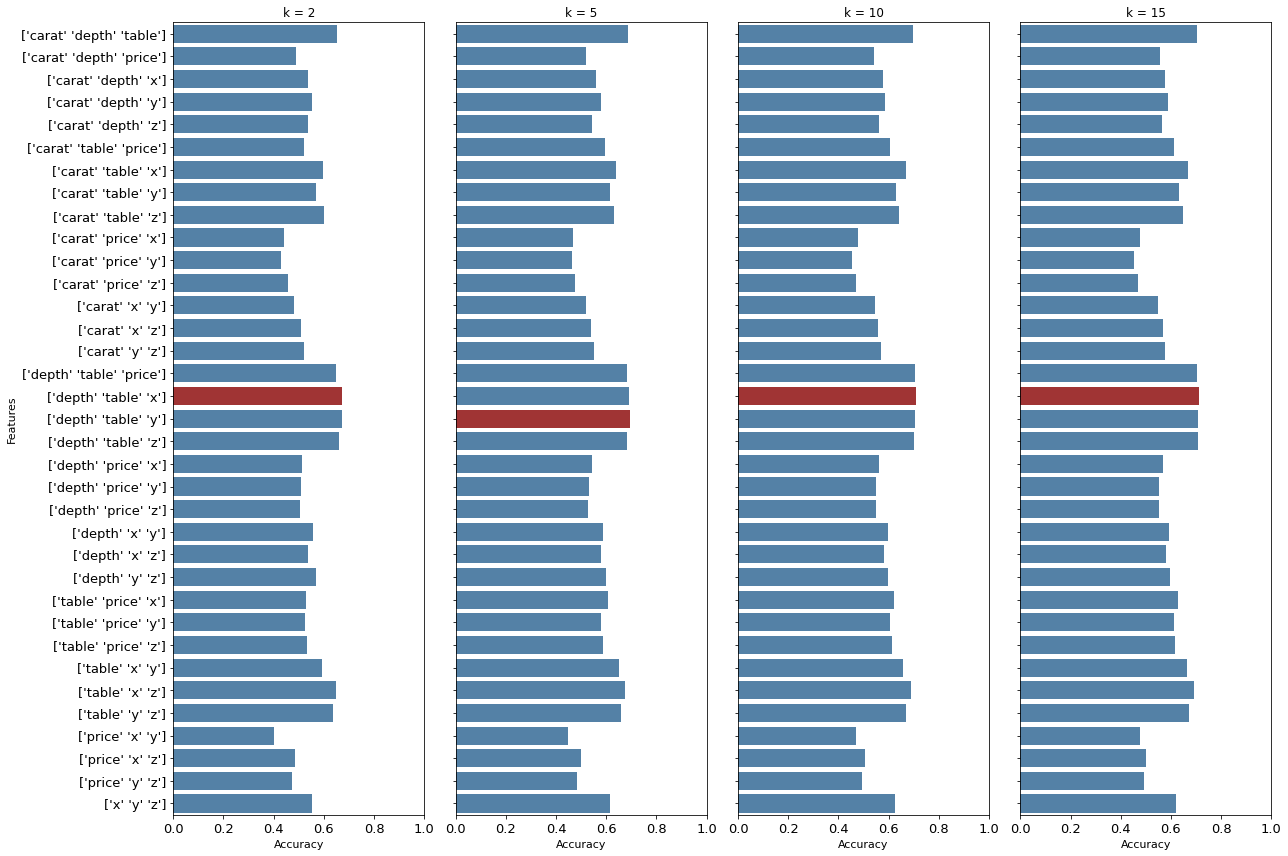

In [20]:
def plotFeatureByCategories(dataframe, feature, category):   
    list_of_ks = dataframe[category].unique()  # Gets the unique categories
    fig, axs = plt.subplots(nrows=1, ncols=list_of_ks.size, figsize=(18, 12))  # Determines the amount of subplots based on the categories

    is_first = True  
    for item, ax in zip(list_of_ks, axs.ravel()):  # Iterates through the axs and categories
        dataframe_aux = dataframe[dataframe[category] == item]  # Filters the dataframe based on the category
        colors = ['steelblue' if (x < max(dataframe_aux[feature])) else 'firebrick' for x in dataframe_aux[feature]]  # Colors the highest value in red

        sns.barplot(ax=ax, data=dataframe_aux, x=feature, y='selector__features', palette=colors)
        ax.set_title(f'k = {item}')
        ax.set(xlim=(0, 1))
        ax.set_ylabel('Features')

        if not is_first:  # Removes the labels if it's not the first plot
            ax.set_ylabel('')
            ax.set_yticklabels('', visible=False)
        is_first = False
        
    fig.tight_layout()
    fig.show()

plotFeatureByCategories(accuracies, 'Accuracy', 'knn__n_neighbors')

O gráfico mostra claramente que a combinação "depth, table, x" é a mais vantajosa em todos dos valores de k checados exceto 5, onde "depth, table, price" tem uma leve vantagem. Com isso, a parte 2 do trabalho está concluída!

## Part 3 - Linear Regression

Primeiro, vamos redefinir os training, testing e validation sets para se adequar ao fato de que agora iremos tentar prever os valores de preço:

In [8]:
y_train_lr = X_train['price']
X_train_lr = X_train.drop(['price'], axis=1)

y_test_lr = X_test['price']
X_test_lr = X_test.drop(['price'], axis=1)

y_val_lr = X_val['price']
X_val_lr = X_val.drop(['price'], axis=1)

Agora, vamos implementar nosso estimator. Além dos que foram pedidos no trabalho, adicionei outros hiperparâmetros que podem ser interessantes para o algoritmo.

In [12]:
from sklearn.metrics import mean_squared_error


class LinearRegressionSolver(BaseEstimator):
    def __init__(self, solver='cf', max_iter=100, learning_rate=0.0001, 
                 weight_decay=0.1, tolerance=1e-6, batch_size=10):
        self.solver = solver 
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.batch_size = batch_size
    
    def fit(self, X, y):
        self.X_train = np.array(np.c_[np.ones((X.shape[0], 1)), X.reset_index(drop=True)])  # Adding the bias term
        self.y_train = np.array(y.reset_index(drop=True))

        if self.solver == 'cf':  # Closed form solution
            A = np.eye(X.shape[1]+1)
            A[0, 0] = 0
            L2_factor = A*self.weight_decay
            inverse = np.linalg.inv(self.X_train.T @ self.X_train + L2_factor)
            self.weights = inverse @ self.X_train.T @ self.y_train

        elif self.solver == 'gd':  # Stochastic gradient descent
            self.weights = np.zeros((X.shape[1]+1))
            for i in range(self.max_iter):
                for start in range(0, self.X_train.shape[0], self.batch_size):
                    randi = np.random.randint(self.X_train.shape[0], size=(self.batch_size))
                    X_batch = self.X_train[randi]
                    y_batch = self.y_train[randi]
                    gradient = X_batch.T @ (X_batch @ self.weights - y_batch)
                    self.weights = self.weights - self.learning_rate * (gradient + (2 * self.weight_decay * self.weights))
                    if np.sum(np.abs(gradient)) < self.tolerance:
                        print("Converges!")
                        break
        return self

    def predict(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X] @ self.weights

Vamos testar e comparar os dois modelos!

In [10]:
lr = LinearRegressionSolver(solver='cf', weight_decay=0.1)
lr.fit(X_train_lr[:10000], y_train_lr[:10000])
y_pred_lr = lr.predict(X_test_lr)

y_test_back = trans_back(X_test_lr, y_test_lr, 3)
y_pred_back = trans_back(X_test_lr, y_pred_lr, 3)

print("Normalized RMSE: ", np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))
print("Real RMSE: ", np.sqrt(mean_squared_error(y_test_back, y_pred_back)))
print("True Values x Predicted Values:")
print(np.c_[y_test_back, np.round(y_pred_back, 0)][:10])

Normalized RMSE:  0.08180214495237242
Real RMSE:  1513.0942751840325
True Values x Predicted Values:
[[ 6391.  6680.]
 [ 1316.  1152.]
 [  769.    54.]
 [ 1841.  2348.]
 [  540.   -36.]
 [14247.  9554.]
 [ 1040.  1353.]
 [ 9355. 10445.]
 [ 6202.  6629.]
 [ 2196.  2934.]]


In [14]:
lr = LinearRegressionSolver(solver='gd', learning_rate=0.001, max_iter=1000, 
                            batch_size=10, weight_decay=0)
lr.fit(X_train_lr[:10000], y_train_lr[:10000])
y_pred_lr = lr.predict(X_test_lr)

y_test_back = trans_back(X_test_lr, y_test_lr, 3)
y_pred_back = trans_back(X_test_lr, y_pred_lr, 3)

print("Normalized RMSE: ", np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))
print("Real RMSE: ", np.sqrt(mean_squared_error(y_test_back, y_pred_back)))
print("True Values x Predicted Values:")
print(np.c_[y_test_back, np.round(y_pred_back, 0)][:10])

Normalized RMSE:  0.08201438282052469
Real RMSE:  1517.0200390312452
True Values x Predicted Values:
[[ 6.3910e+03  6.6720e+03]
 [ 1.3160e+03  1.1300e+03]
 [ 7.6900e+02  7.0000e+00]
 [ 1.8410e+03  2.3490e+03]
 [ 5.4000e+02 -6.9000e+01]
 [ 1.4247e+04  9.5200e+03]
 [ 1.0400e+03  1.2740e+03]
 [ 9.3550e+03  1.0379e+04]
 [ 6.2020e+03  6.6360e+03]
 [ 2.1960e+03  2.9240e+03]]


Podemos ver que as previsões não são muito precisas. É possível encontrar até mesmo preços negativos! Outra observação é que a Stochastic Gradient Descent parece ter uma performance ligeiramente pior que o modelo Closed Form. Agora, vamos plotar os valores reais e os previstos:

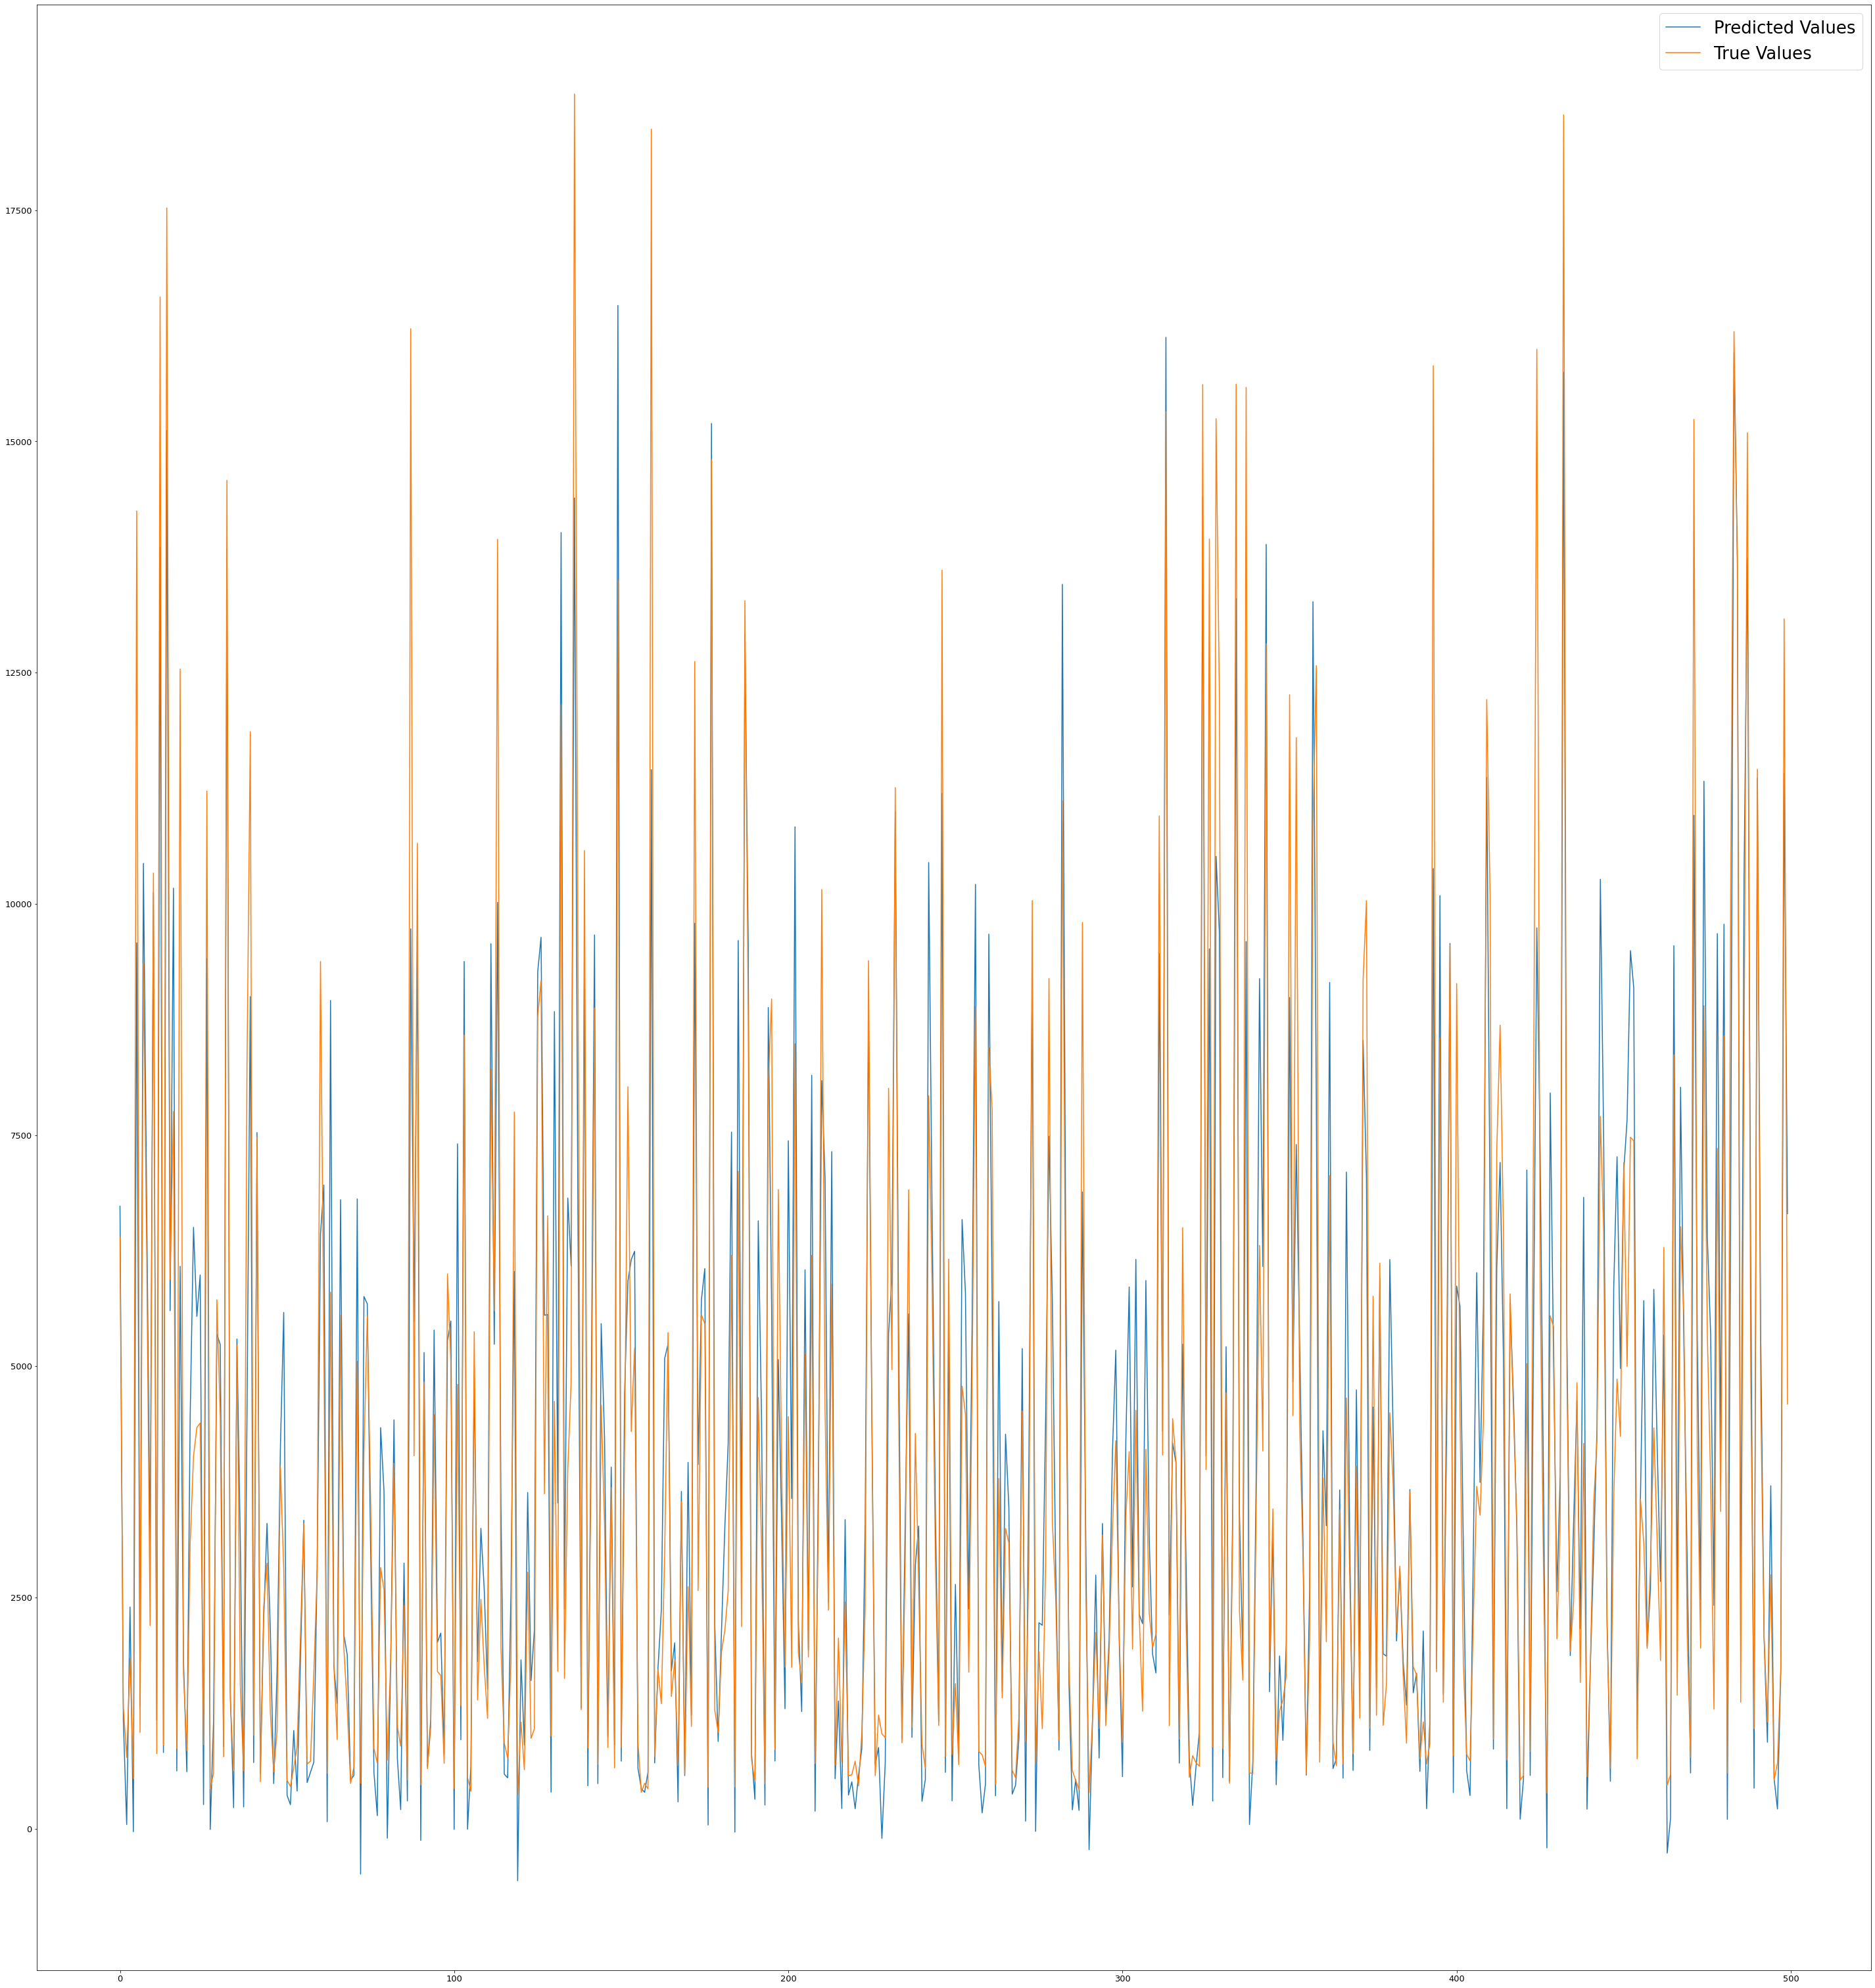

In [25]:
fig, ax = plt.subplots(figsize=(50, 55))

ax.plot(np.arange(0,trans_back(X_test_lr, y_pred_lr, 3)[:500].size), 
        trans_back(X_test_lr, y_pred_lr, 3)[:500],
        label="Predicted Values")
ax.plot(np.arange(0,trans_back(X_test_lr, y_test_lr, 3)[:500].size), 
        trans_back(X_test_lr, y_test_lr, 3)[:500],
        label="True Values")

leg = ax.legend(prop={"size": 26})

Podemos observar que o modelo não é capaz de prever bem esses diversos picos de preço mais altos. Com isso, a parte 3 está concluída!

## Part 4 - Model Comparison
### Prevendo a feature "cut":

Vamos escolher os modelos para comparação. Um deles será o próprio modelo de knn do Scikit-Learn, e os outros serão o modelo de Decision Tree Classifier, e o Random Forest Classifier. Para usar esses outros modelos, é necessário primeiro codificar as features categóricas:

In [26]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(np.array(y_diamonds).reshape(-1, 1))

y_train_ohe = ohe.transform(np.array(y_train).reshape(-1, 1))
y_test_ohe = ohe.transform(np.array(y_test).reshape(-1, 1))
y_val_ohe = ohe.transform(np.array(y_val).reshape(-1, 1))

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

X_train_val_lr = pd.concat([X_train_lr, X_val_lr], axis=0)
y_train_val_lr = np.concatenate([y_train_lr, y_val_lr], axis=0)

Primeiramente, vamos começar pelo KNN do SciKit-Learn:

In [27]:
skl_knn = KNeighborsClassifier()


# Set of hyperparameter combinations to try out
param_grid_knn = {'n_neighbors': range(1, 31)}

grid_search_knn = GridSearchCV(skl_knn, 
                           param_grid=param_grid_knn, 
                           cv=4, 
                           scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

accuracies_skl = pd.concat(
    [
        pd.DataFrame(grid_search_knn.cv_results_["params"]),
        pd.DataFrame(grid_search_knn.cv_results_["mean_test_score"], columns=["Accuracy"])
    ], 
    axis=1
)

accuracies_skl.sort_values(by="Accuracy", ascending=False).head(10)

,n_neighbors,Accuracy
13,14,0.702939
15,16,0.702777
14,15,0.702544
17,18,0.702498
16,17,0.701685
19,20,0.701638
11,12,0.701638
12,13,0.701499
10,11,0.701313
18,19,0.701104


In [28]:
# Training the best hyperparameters model with train + val set
skl_knn = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_["n_neighbors"])
skl_knn.fit(X_train_val, y_train_val)

skl_knn_acc = accuracy_score(y_test, grid_search_knn.predict(X_test))
print("Accuracy: ", skl_knn_acc)

Accuracy:  0.7073312420123156


Agora, vamos testar diversos hiperparâmetros de uma DecisionTreeClassifier:

In [29]:
from sklearn.tree import DecisionTreeClassifier


depth = list(range(3, 30, 2))
depth.append(None)
param_grid_dtc = {'max_depth': depth,
                  "criterion": ["gini", "entropy"]}

dtc = DecisionTreeClassifier()

grid_search_dtc = GridSearchCV(dtc, 
                           param_grid=param_grid_dtc, 
                           cv=4, 
                           scoring='accuracy')

grid_search_dtc.fit(X_train, y_train_ohe)

accuracies_dtc = pd.concat(
    [
        pd.DataFrame(grid_search_dtc.cv_results_["params"]),
        pd.DataFrame(grid_search_dtc.cv_results_["mean_test_score"], columns=["Accuracy"])
    ], 
    axis=1
)
accuracies_dtc.sort_values(by="Accuracy", ascending=False).head(10)

,criterion,max_depth,Accuracy
20,entropy,13.0,0.721947
5,gini,13.0,0.721343
6,gini,15.0,0.719554
21,entropy,15.0,0.718508
8,gini,19.0,0.717300
7,gini,17.0,0.716556
4,gini,11.0,0.715673
22,entropy,17.0,0.714628
19,entropy,11.0,0.714395
9,gini,21.0,0.712861


In [30]:
# Training the best hyperparameters model with train + val set
dtc = DecisionTreeClassifier(criterion='gini', max_depth=13)
dtc.fit(X_train_val, y_train_val)

dtc_acc = accuracy_score(y_test_ohe, grid_search_dtc.predict(X_test))
print("Accuracy: ", dtc_acc)

Accuracy:  0.7288253746950157


Agora, vamos tentar com o RandomForestClassifier:

In [31]:
from sklearn.ensemble import RandomForestClassifier


# Testing with fewer params because it takes a lot of time (~12 minutes)
param_grid_rfc = {'max_depth': [19, 25],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [200, 300]
}

rfc = RandomForestClassifier()

grid_search_rfc = GridSearchCV(rfc, 
                               param_grid=param_grid_rfc, 
                               cv=4, 
                               scoring='accuracy')

grid_search_rfc.fit(X_train, y_train_ohe)

accuracies_rfc = pd.concat(
    [
        pd.DataFrame(grid_search_rfc.cv_results_["params"]),
        pd.DataFrame(grid_search_rfc.cv_results_["mean_test_score"], columns=["Accuracy"])
    ], 
    axis=1
)
accuracies_rfc.sort_values(by="Accuracy", ascending=False).head(10)

,criterion,max_depth,n_estimators,Accuracy
4,entropy,19,200,0.741094
6,entropy,25,200,0.740630
7,entropy,25,300,0.740490
5,entropy,19,300,0.740304
0,gini,19,200,0.739770
1,gini,19,300,0.739352
2,gini,25,200,0.739166
3,gini,25,300,0.739050


In [32]:
# Training the best hyperparameters model with train + val set
rfc = RandomForestClassifier(max_depth=25, criterion='entropy', n_estimators=300)
rfc.fit(X_train_val, y_train_val)

rfc_acc = accuracy_score(y_test_ohe, grid_search_rfc.predict(X_test))
print("Validation Accuracy: ", rfc_acc)

Validation Accuracy:  0.7505518763796909


Por último, vamos calcular a accuracy do meu modelo implementado:

In [33]:
pipeline = Pipeline(
    [
        ('selector', FeatureSelector()),
        ('knn', KNearestNeighbours()),
    ]
)


pipeline.set_params(
                    knn__k=15, 
                    selector__features=['table', 'depth', 'x'],
                    knn__distances='euclidean'
                    )
pipeline.fit(X_train_val, y_train_val)
y_pred = pipeline.predict(X_test)

own_knn_acc = accuracy_score(y_pred, y_test)
print("Validation Accuracy: ", own_knn_acc)

Validation Accuracy:  0.7151156035784826


Vamos agora montar os DataFrames de comparação entre esses resultados:

In [34]:
classify_gridsearch = pd.concat(
    [
        pd.DataFrame(accuracies["Accuracy"]).sort_values(by="Accuracy", ascending=False).head(10),
        pd.DataFrame(accuracies_dtc["Accuracy"]).sort_values(by="Accuracy", ascending=False).head(10),
        pd.DataFrame(accuracies_rfc["Accuracy"]).sort_values(by="Accuracy", ascending=False).head(10),
        pd.DataFrame(accuracies_skl["Accuracy"]).sort_values(by="Accuracy", ascending=False).head(10),
    ],
    axis=1
)

classify_gridsearch.columns = ["Own KNN", "Decision Tree", "Random Forest", "Sklearn KNN"]

classify_validation = {
    "Model": ["Own KNN", "Decision Tree", "Random Forest", "Sklearn KNN"],
    "Accuracy": [own_knn_acc, dtc_acc, rfc_acc, skl_knn_acc]
}

classify_validation = pd.DataFrame(classify_validation)
classify_validation.sort_values(by="Accuracy", ascending=False, inplace=True)

E finalmente, plotar eles para podermos compará-los:

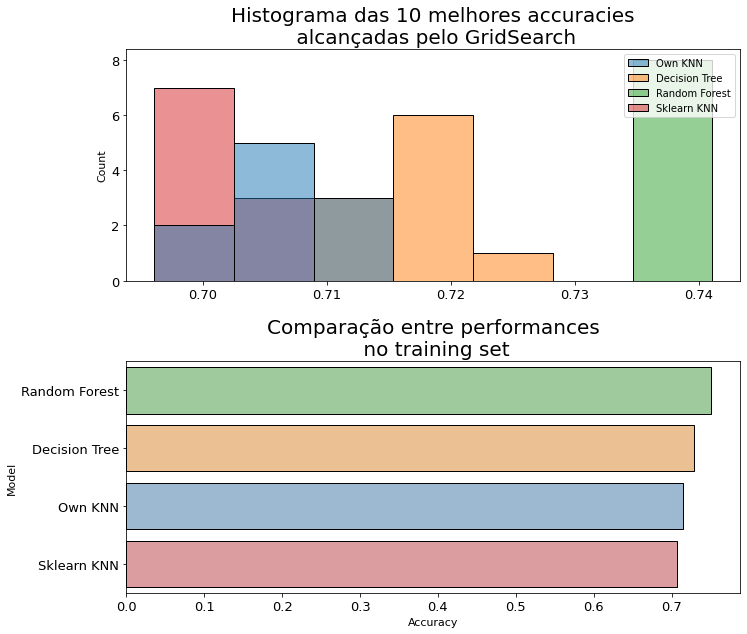

In [35]:
colors = ["#97D196", "#F9C186", "#94B8DA", "#E59395"]

fig, axs = plt.subplots(2, figsize=(11, 10))
sns.histplot(classify_gridsearch, ax=axs[0], color=sns.color_palette("Set2", 4))
sns.barplot(y="Model", x="Accuracy", data=classify_validation, ax=axs[1],
            linewidth=1, edgecolor="black", palette=colors)

axs[0].set_title(f"Histograma das 10 melhores accuracies\n alcançadas pelo GridSearch", fontsize=20)
axs[1].set_title(f"Comparação entre performances\n no training set", fontsize=20)
fig.subplots_adjust(hspace=0.35)
fig.show()

O modelo de Random Forest possui uma vantagem considerável para este problema, quando comparado aos outros modelos testados. Um possível motivo para isso é que o Random Forest é um modelo mais robusto, que possui a capacidade de notar certas interrelações entre as features que não são percebidas pelos outros modelos. 

### Prevendo a feature "price":

Vamos escolher os modelos para comparação. Testaremos o próprio modelo de Ridge Regression e SGD Regression do Scikit-Learn, além de testar o modelo SupportVectorRegression. Primeiro, vamos testar o Ridge:

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

skl_lr = Ridge()

search_params = {'alpha': loguniform(1e-6, 1e3)}
rand_search_lr = RandomizedSearchCV(skl_lr, 
                                    param_distributions=search_params, 
                                    cv=4, 
                                    scoring='neg_root_mean_squared_error')
rand_search_lr.fit(X_train_lr, y_train_lr)

accuracies_skl_lr = pd.concat(
    [
        pd.DataFrame(rand_search_lr.cv_results_["params"]),
        pd.DataFrame(rand_search_lr.cv_results_["mean_test_score"], columns=["Negative RMSE"])
    ], 
    axis=1
)
accuracies_skl_lr.sort_values(by="Negative RMSE", ascending=False).head(10)

,alpha,Negative RMSE
6,0.277678,-0.080456
1,0.140527,-0.080461
4,0.001518,-0.080505
8,0.000742,-0.080506
3,0.000086,-0.080506
5,0.000002,-0.080506
0,3.429571,-0.081323
2,46.380806,-0.088605
7,200.079737,-0.100245
9,785.229771,-0.138427


In [37]:
skl_lr = Ridge(alpha=rand_search_lr.best_params_["alpha"])
skl_lr.fit(X_train_val_lr, y_train_val_lr)
y_pred_lr = skl_lr.predict(X_test_lr)

# Converts back to original scale
y_test_back_lr = trans_back(X_test_lr, y_test_lr, 3)
y_pred_back_lr = trans_back(X_test_lr, y_pred_lr, 3)

rmse_skl_lr = np.sqrt(mean_squared_error(y_test_back_lr, y_pred_back_lr))
print("Testing RMSE: ", rmse_skl_lr)

Testing RMSE:  1509.4601625461787


Agora, vamos tentar o SGD:

In [38]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

search_params = [
    {
        'loss': ['squared_loss'],
        'penalty': ['l1', 'l2'],
        'alpha': loguniform(1e-6, 1e3)
    },
    {
        'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'penalty': ['l1', 'l2'],
        'alpha': loguniform(1e-6, 1e3),
        'epsilon': loguniform(1e-6, 1e3),
    }
]
rand_search_sgd = RandomizedSearchCV(sgd, 
                                    param_distributions=search_params, 
                                    cv=4, 
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=100)
rand_search_sgd.fit(X_train_lr, y_train_lr)


accuracies_sgd = pd.concat(
    [
        pd.DataFrame(rand_search_sgd.cv_results_["params"]),
        pd.DataFrame(rand_search_sgd.cv_results_["mean_test_score"], columns=["Negative RMSE"])
    ], 
    axis=1
)

accuracies_sgd.sort_values(by="Negative RMSE", ascending=False).head(10)

,alpha,epsilon,loss,penalty,Negative RMSE
70,0.000003,0.000101,squared_epsilon_insensitive,l2,-0.088352
74,0.000094,0.000114,squared_epsilon_insensitive,l1,-0.088367
13,0.000023,0.002173,squared_epsilon_insensitive,l1,-0.088430
32,0.000191,0.003333,squared_epsilon_insensitive,l2,-0.088441
30,0.000111,0.000244,squared_epsilon_insensitive,l1,-0.088445
83,0.001166,0.128215,epsilon_insensitive,l1,-0.089012
11,0.000001,NaN,squared_loss,l1,-0.089855
19,0.000002,NaN,squared_loss,l1,-0.089859
37,0.000003,6.274980,huber,l2,-0.089870
33,0.000001,NaN,squared_loss,l2,-0.089873


In [39]:
sgd = SGDRegressor(alpha=rand_search_sgd.best_params_["alpha"], 
                   loss=rand_search_sgd.best_params_["loss"], 
                   penalty=rand_search_sgd.best_params_["penalty"], 
                   epsilon=rand_search_sgd.best_params_["epsilon"])
                   
sgd.fit(X_train_val_lr, y_train_val_lr)
y_pred_sgd = sgd.predict(X_test_lr)

# Converts back to original scale
y_pred_back_sgd = trans_back(X_test_lr, y_pred_sgd, 3)

rmse_sgd = np.sqrt(mean_squared_error(y_test_back_lr, y_pred_back_sgd))
print("Testing RMSE: ", rmse_sgd)

Testing RMSE:  1650.5063122965885


Vamos agora testar o SupportVectorRegression:

In [40]:
from sklearn.svm import LinearSVR
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)  

svr = LinearSVR()

search_params = [
    {
        'C': [0.01, 0.1, 1, 10],
        'epsilon': [0.001, 0.01, 0.1, 0],
    }
]

grid_search_svr = GridSearchCV(svr, 
                               param_grid=search_params, 
                               cv=4, 
                               scoring='neg_root_mean_squared_error')
grid_search_svr.fit(X_train_lr, y_train_lr)


accuracies_svr = pd.concat(
    [
        pd.DataFrame(grid_search_svr.cv_results_["params"]),
        pd.DataFrame(grid_search_svr.cv_results_["mean_test_score"], columns=["Negative RMSE"])
    ], 
    axis=1
)

accuracies_svr.sort_values(by="Negative RMSE", ascending=False).head(10)

,C,epsilon,Negative RMSE
5,0.1,0.010,-0.082608
9,1.0,0.010,-0.082734
11,1.0,0.000,-0.082781
13,10.0,0.010,-0.082787
7,0.1,0.000,-0.082845
4,0.1,0.001,-0.082845
8,1.0,0.001,-0.082848
10,1.0,0.100,-0.083012
14,10.0,0.100,-0.084311
6,0.1,0.100,-0.084749


In [41]:
svr = LinearSVR(C=grid_search_svr.best_params_["C"], 
                epsilon=grid_search_svr.best_params_["epsilon"])
                   
svr.fit(X_train_val_lr, y_train_val_lr)
y_pred_svr = svr.predict(X_test_lr)

# Converts back to original scale
y_pred_back_svr = trans_back(X_test_lr, y_pred_svr, 3)

rmse_svr = np.sqrt(mean_squared_error(y_test_back_lr, y_pred_back_svr))
print("Testing RMSE: ", rmse_svr)

Testing RMSE:  1538.4836051404166


Por último, vamos testar alguns valores de weight decay em meu modelo:

In [42]:
own_lr = LinearRegressionSolver()

search_params = [{"weight_decay": loguniform(1e-8, 1e2)}]
rand_search_own_lr = RandomizedSearchCV(own_lr, 
                                        param_distributions=search_params, 
                                        cv=4, 
                                        scoring='neg_root_mean_squared_error',
                                        n_iter=100)
rand_search_own_lr.fit(X_train_lr, y_train_lr)


accuracies_own_lr = pd.concat(
    [
        pd.DataFrame(rand_search_own_lr.cv_results_["params"]),
        pd.DataFrame(rand_search_own_lr.cv_results_["mean_test_score"], columns=["Negative RMSE"])
    ], 
    axis=1
)

accuracies_own_lr.sort_values(by="Negative RMSE", ascending=False).head(10)

,weight_decay,Negative RMSE
16,0.242817,-0.080455
56,0.207751,-0.080456
72,0.173369,-0.080458
44,0.125481,-0.080463
78,0.055858,-0.080479
84,0.033619,-0.080488
25,0.032174,-0.080488
8,0.030911,-0.080489
69,0.023343,-0.080493
4,0.022258,-0.080493


In [43]:
own_lr = LinearRegressionSolver(weight_decay=rand_search_own_lr.best_params_["weight_decay"])
                   
own_lr.fit(pd.DataFrame(X_train_val_lr), pd.DataFrame(y_train_val_lr))
y_pred_own_lr = svr.predict(X_test_lr)

# Converts back to original scale
y_pred_back_own_lr = trans_back(X_test_lr, y_pred_own_lr, 3)

rmse_own_lr = np.sqrt(mean_squared_error(y_test_back_lr, y_pred_back_own_lr))
print("Testing RMSE: ", rmse_own_lr)

Testing RMSE:  1538.4836051404166


Agora, basta montar os gráficos:

In [44]:
regression_gridsearch = pd.concat(
    [
        pd.DataFrame(accuracies_own_lr["Negative RMSE"]).sort_values(by="Negative RMSE", ascending=False).head(10),
        pd.DataFrame(accuracies_svr["Negative RMSE"]).sort_values(by="Negative RMSE", ascending=False).head(10),
        pd.DataFrame(accuracies_sgd["Negative RMSE"]).sort_values(by="Negative RMSE", ascending=False).head(10),
        pd.DataFrame(accuracies_skl_lr["Negative RMSE"]).sort_values(by="Negative RMSE", ascending=False).head(10),
    ],
    axis=1
)


regression_gridsearch.columns = ["Own Ridge Regression",
                                 "Linear Support Vector Regression", 
                                 "SKL Stochastic Gradient Descent",
                                 "SLK Ridge Regression"]

regression_RMSE = {
    "Model": ["Own Ridge Regression",
              "Linear Support Vector Regression", 
              "SKL Stochastic Gradient Descent",
              "SKL Ridge Regression"],
    "RMSE": [rmse_own_lr, rmse_svr, rmse_sgd, rmse_skl_lr]
}

regression_RMSE = pd.DataFrame(regression_RMSE)
regression_RMSE.sort_values(by="RMSE", ascending=True, inplace=True)

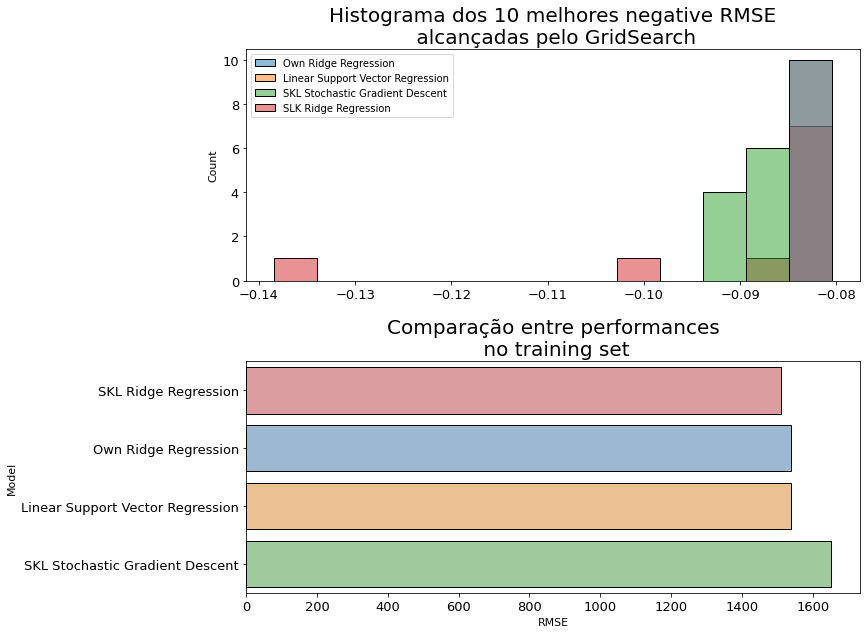

In [45]:
colors = ["#E59395", "#94B8DA", "#F9C186", "#97D196"]

fig, axs = plt.subplots(2, figsize=(11, 10))
sns.histplot(regression_gridsearch, ax=axs[0], color=sns.color_palette("Set2", 4))
sns.barplot(y="Model", x="RMSE", data=regression_RMSE, ax=axs[1],
            linewidth=1, edgecolor="black", palette=colors)

axs[0].set_title(f"Histograma dos 10 melhores negative RMSE\n alcançadas pelo GridSearch", fontsize=20)
axs[1].set_title(f"Comparação entre performances\n no training set", fontsize=20)
fig.subplots_adjust(hspace=0.35)
fig.show()

Podemos ver que o modelo de Ridge Regression do SciKit-Learn se mostrou o mais preciso em nossos testes no training set. Assim, o trabalho está concluído!